# Exploration of Historical NBA Team Efficiency (Part II)
On last week's episode... ugh that was cringey sorry. Last post we started looking at efficiency which, again, we have defined as:
$$ORtg=\frac{Points\ Scored}{100\ Possessions}$$

$$DRtg=\frac{Points\ Allowed}{100\ Possessions}$$

We also defined a possession as:
$$Poss=FGA+0.5\times FTA-ORB+TO$$

We took a look at FGA and FTA to see if there was anything that caught our eye. Not really. In this post, I want to explore the other two factors (or at least one of them anyways) and see if there's anything that catches our eye here.

## Rebounding
So for efficiency, everytime you get an offensive rebound, it extends your possession. The formula which, again is an **ESTIMATE** of possesssions, assumes that every possession ends in either a TO or a shot off (FG/FT).

A shot can either go in or not. Goes in? Possession done, other team gets the ball. Doesn't go in? It can either result in an
- Defensive rebound
- Offensive rebound
- Team rebound (we don't account for these here)

On a defensive rebound, the other team gets the ball. On an offensive rebound, we **retain** possession, giving us an opportunity for ANOTHER FGA/FTA/TO. Therefore, this formula is assuming that every ORB lead to one of these... again, not completely correct due to team rebounds, end of quarter etc, but good enough for an estimate.

The formula is therefore subtracting all ORBs from possessions because it essentially erases an FGA missed or 1/2 of an FTA missed. An ORB actually slows down our pace because it slows down our possessions, but it can make us more efficient because, even if we missed our first field goal, we still have the chance to get a score on the ORB. This contradicts my assumption last post actually of assuming FGA / FTA is proportional to pace. ORBs actually go **against** that because each ORB has the possibility of adding an FGA / FTA while **SLOWING DOWN** the pace. But anyways, this will depend on how many ORBs teams are getting. If someone gets 20 ORBs / game that all lead to FGA / FTAs, it will make a big difference. If teams are only getting 10 ORB, only some of which are leading to FGA / FTAs anyways, then it doesn't impact the numbers too much. Again, this is a simple analysis and I'm dumb, so I'll leave this assumption hanging for now.

For kicks, I'm just going to look at all rebounding data because it feels like a waste not to look at DRB when the DATA IS RIGHT THERE!!

In [6]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
%%R
library(ggplot2)
library(gridExtra)
library(scales)

In [8]:
# Load libraries & initial config
import pandas as pd
import numpy as np
import boto3
from StringIO import StringIO

In [9]:
# Retrieve team stats from S3
teamAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/teamAggDfToAnalyze.csv', index_col = 0)
print teamAggDfToAnalyze.dtypes

baseStats_Season             object
perGameStats_Tm              object
baseStats_W                   int64
baseStats_L                   int64
baseStats_W/L%              float64
baseStats_SRS               float64
baseStats_Pace              float64
baseStats_Rel_Pace          float64
baseStats_ORtg              float64
baseStats_Rel_ORtg          float64
baseStats_DRtg              float64
baseStats_Rel_DRtg          float64
perGameStats_Age            float64
perGameStats_FG             float64
perGameStats_FGA            float64
perGameStats_FG%            float64
perGameStats_2P             float64
perGameStats_2PA            float64
perGameStats_2P%            float64
perGameStats_3P             float64
perGameStats_3PA            float64
perGameStats_3P%            float64
perGameStats_FT             float64
perGameStats_FTA            float64
perGameStats_FT%            float64
perGameStats_ORB            float64
perGameStats_DRB            float64
perGameStats_TRB            

In [15]:
def rbdPrepare(team = None):
    if team is None:
        teamDf = teamAggDfToAnalyze
    else:
        teamDf = teamAggDfToAnalyze[teamAggDfToAnalyze['perGameStats_Tm'] == team]

    # Prepare ORB / DRB data
    teamRbdDf = pd.melt(
        teamDf[[
            'season_start_year',
            'perGameStats_ORB',
            'perGameStats_DRB'
        ]],
        id_vars=['season_start_year'], 
        value_vars=['perGameStats_ORB', 'perGameStats_DRB'],
        var_name='rebound_type', 
        value_name='rebounds'
    )
    
    teamRbdDf = teamRbdDf.groupby(['season_start_year', 'rebound_type']).agg({
        'rebounds': np.average,   # We average the percentage here because when we look at league averages, we will have more than one record per year and shot type
    })
    
    teamRbdDf.reset_index(inplace = True)
    
    print teamRbdDf
    
    return teamRbdDf

rapsRbdDf = rbdPrepare('TOR')

    season_start_year      rebound_type  rebounds
0                1995  perGameStats_DRB      27.0
1                1995  perGameStats_ORB      13.1
2                1996  perGameStats_DRB      27.5
3                1996  perGameStats_ORB      13.8
4                1997  perGameStats_DRB      26.2
5                1997  perGameStats_ORB      14.5
6                1998  perGameStats_DRB      28.9
7                1998  perGameStats_ORB      14.2
8                1999  perGameStats_DRB      29.9
9                1999  perGameStats_ORB      13.4
10               2000  perGameStats_DRB      30.8
11               2000  perGameStats_ORB      13.6
12               2001  perGameStats_DRB      28.5
13               2001  perGameStats_ORB      13.6
14               2002  perGameStats_DRB      28.7
15               2002  perGameStats_ORB      12.5
16               2003  perGameStats_DRB      29.5
17               2003  perGameStats_ORB      10.1
18               2004  perGameStats_DRB      29.8


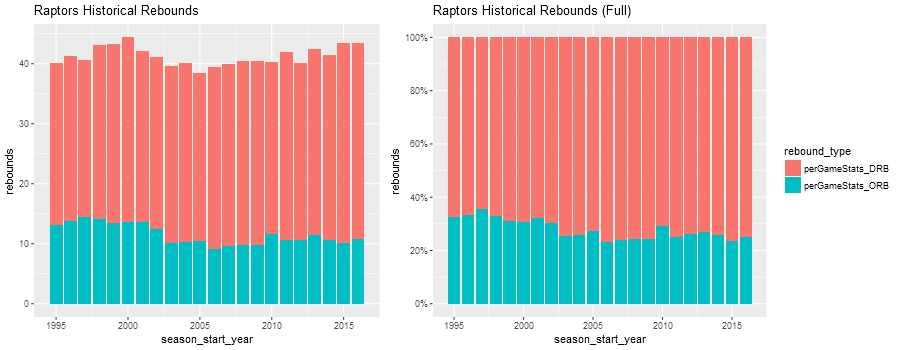

In [18]:
%%R -i rapsRbdDf -w 900 -h 350 -u px

rbdPlot <- function(rbdDf, teamName){
    # 2PA / 3PA stacked bar
    stackedBarRbd = ggplot(
        rbdDf,
        aes(
            x = season_start_year,
            y = rebounds,
            fill = rebound_type
        )
    ) + 
    geom_bar(stat = 'identity') +
    guides(fill = FALSE) +
    ggtitle(sprintf("%s Historical Rebounds", teamName)) + 
    scale_fill_manual(values=c('#F8766D', '#00BFC4', '#00BA38'))

    # 2PA / 3PA 100 stacked bar
    stackedBar100Rbd = ggplot(
        rbdDf,
        aes(
            x = season_start_year,
            y = rebounds,
            fill = rebound_type,
            position = "fill"
        )
    ) + 
    geom_bar(position = "fill", stat = "identity") + 
    scale_y_continuous(labels = percent, breaks = seq(0, 1, 0.2)) +
    ggtitle(sprintf("%s Historical Rebounds (Full)", teamName)) + 
    scale_fill_manual(values=c('#F8766D', '#00BFC4', '#00BA38'))

    grid.arrange(stackedBarRbd, stackedBar100Rbd, ncol = 2, widths = 3:4)
}

rbdPlot(rapsRbdDf, 'Raptors')

Let's look at league averages:

In [20]:
leagueRbdDf = rbdPrepare()

     season_start_year      rebound_type   rebounds
0                 1946  perGameStats_DRB        NaN
1                 1946  perGameStats_ORB        NaN
2                 1947  perGameStats_DRB        NaN
3                 1947  perGameStats_ORB        NaN
4                 1948  perGameStats_DRB        NaN
5                 1948  perGameStats_ORB        NaN
6                 1949  perGameStats_DRB        NaN
7                 1949  perGameStats_ORB        NaN
8                 1950  perGameStats_DRB        NaN
9                 1950  perGameStats_ORB        NaN
10                1951  perGameStats_DRB        NaN
11                1951  perGameStats_ORB        NaN
12                1952  perGameStats_DRB        NaN
13                1952  perGameStats_ORB        NaN
14                1953  perGameStats_DRB        NaN
15                1953  perGameStats_ORB        NaN
16                1954  perGameStats_DRB        NaN
17                1954  perGameStats_ORB        NaN
18          

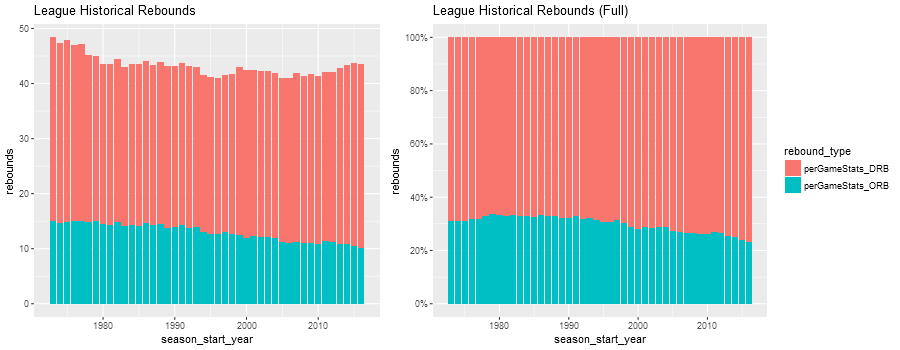

In [21]:
%%R -i leagueRbdDf -w 900 -h 350 -u px
rbdPlot(leagueRbdDf, 'League')

There we go, another metric that I didn't really raelize. Offensive rebounding historically I guess has accounted for, let's say, 25-30% of rebounds that a team has secured. Somehow I thought it was much less, like 10%. You learn something new, and how dumb you are while you're at it, every day.

Offensive rebounding does seem to be on the decline, but I feel I don't know enough to really speculate what's going on. I'd probably have to take a look at how many shots are being taken in a game first. We've already determined that more 3's are being taken, so I could make up a theory about how 3 point shots generally rebound further away from the basket than jump hooks or runners do, so maybe that nullifies the effect of boxing out a bit? Not quite sure and I won't speculate any further as a armchair basketball player.

To see just how much ORBs affect efficiency, we'd probably look at second chance points as a more direct measure, but I don't have that metric unfortunately. If I draw a scatterplot to see how ORBs correlate with ORTG, I should see a direct relationship according to the formula...? All varaibles are not held constant here and I understand that but I'm an armchair aren't I. LET'S DO IT.

In [24]:
teamAggRbdOrtgDf = teamAggDfToAnalyze[[
    'baseStats_ORtg',
    'perGameStats_ORB'
]]

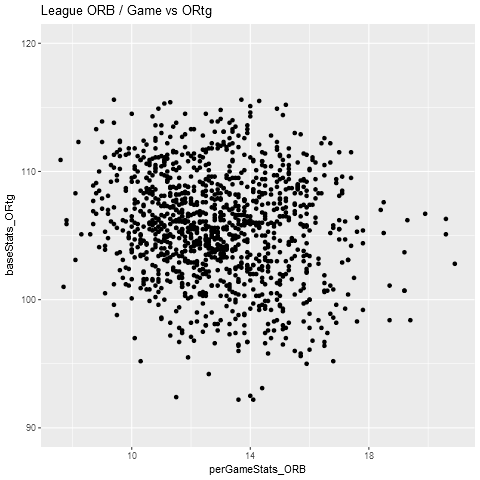

In [29]:
%%R -i teamAggRbdOrtgDf

# ORB scatterplot
scatterRbdOrtg = ggplot(
    teamAggRbdOrtgDf,
    aes(
        x = perGameStats_ORB,
        y = baseStats_ORtg
    )
) + 
geom_point() +
ggtitle('League ORB / Game vs ORtg') +
scale_y_continuous(limits = c(90, 120))

grid.arrange(scatterRbdOrtg, ncol = 1)

I have never seen less correlation in my life. In fact I think if you actually look up the antonym of correlation on [http://www.thesaurus.com](http://www.thesaurus.com), you actually see this picture. Yes, that's right. the 2017 snapshot of NBA League ORB / Game vs. ORtg. I've never wondered what the opposite of a straight line was, but I think I've found the answer here. It's a circle. A goddamn circle. Would the correlation here be zero? I mean, the shape is a goddamn circle, it must be zero.

In [35]:
print teamAggRbdOrtgDf.corr('pearson').iat[0,1]

-0.149328128476


How is this not zero? Don't get me wrong, 0.15 is bad, but it's not zero, which this should be. I realize that I didn't adjust for pace here, but still, ZERO CORRELATION? ORBs ARE PERCEIVED TO BE SO VALUABLE AND THERE IS NO CORRELATION? I will never box out and get another offensive rebound in my life in pickup. The math checks out.

Here's what comes up when I google image "no correlation":
![](https://i.stack.imgur.com/LDrXq.png)

I bet you thought I just reposted the ORB / Game vs. ORtg graph didn't you? I didn't! I swear!!

OKAY, I'm going to give the world the benefit of the doubt before I give that to myself. The fact that I didn't account for pace must be throwing something off. Or maybe I need to be thinking about rebounding a different way in general.

ORB... what affects this... well I guess for one thing, pace definitely matters right? If you play a fast pace, or play to your opponent who plays a fast pace, you could not be getting any more % of rebounds as ORBs you normally would be getting, but you would definitely get more absolute ORBs. Perhaps let's try % of rebound as ORBs vs ORtg?

In [43]:
teamAggRbdPercOrtgDf = teamAggDfToAnalyze[[
    'baseStats_ORtg',
    'perGameStats_TRB',
    'perGameStats_ORB'
]]

teamAggRbdPercOrtgDf['percent_rebound_orb'] = teamAggRbdPercOrtgDf['perGameStats_ORB']/teamAggRbdPercOrtgDf['perGameStats_TRB']

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


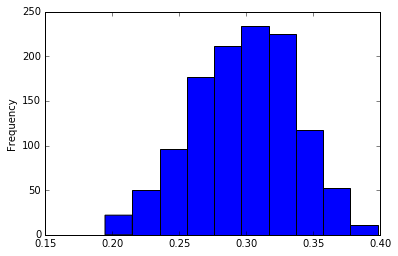

In [44]:
teamAggRbdPercOrtgDf['percent_rebound_orb'].plot('hist')

Cool, this is about consistent with what we discovered before. Offensive boards accounting for ~30% of all shots. Let's check out the correlation with ORtg now:

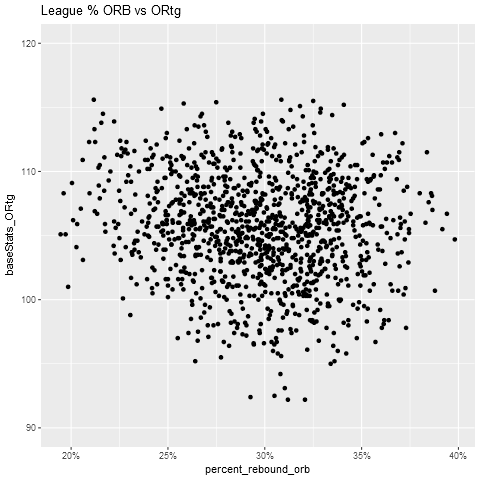

In [54]:
%%R -i teamAggRbdPercOrtgDf

# % ORB scatterplot
scatterRbdOrtg = ggplot(
    teamAggRbdPercOrtgDf,
    aes(
        x = percent_rebound_orb,
        y = baseStats_ORtg
    )
) + 
geom_point() +
ggtitle('League % ORB vs ORtg') +
scale_y_continuous(limits = c(90, 120)) +
scale_x_continuous(label = percent)

grid.arrange(scatterRbdOrtg, ncol = 1)

In [47]:
print teamAggRbdOrtgDf[['percent_rebound_orb', 'baseStats_ORtg']].corr('pearson').iat[0,1]

-0.112029508937


I can't believe I've done it. Something <span style="color:red">**EVEN LESS CORRELATED THAN THE PREVIOUS GRAPH**</span>. You ever feel like despite your best efforts, you're just not destined to be somewhere or do something? There's a bit of that creeping up here. Now I wish I didn't make fun of that first one so much.

Okay, something is still wrong. No, I am not smarter than the world or reddit. Another thing I can think of is, a team's own offensive and defensive boards aren't really competing with each other. That is, the percentage of ORB's between a team's ORBs and DRBs maybe isn't telling us anything.

#### Scenario 1
Raptors shoot 100 FG and miss 10 of them. Rockets shoot 100 FG and miss 50 of them. They each ORB half their misses.

Final stats: Raptors with 25 DRB and 5 ORB. Rockets with 5 DRB and 25 ORB.

According to my previous assumptions, rockets must be a better team in this case? The reality is the raptors probably won by a landslide because they didn't miss many shots, whereas the rockets missed half their shots. Raps didn't get any ORBs because they didn't have to. They were doing the work on the offensive end putting the ball in the hoop.

#### Scenario 2
Both teams shoot 100 FG and miss 50 of them. They each ORB half their misses.

Final stats: Both teams with 25 DRB and 25 ORB.

It's hard to tell who won this game. Depends on what types of shots they were taking and how many FTs were taken.

-------------

Perhaps a better way to measure ORB success (and now the pretty obviously logical way) is to pit a team's ORBs against the opposing team's DRBs. This will give an indication on how good of an offensive rebounding team a team is, and hopefully will give a better sense of efficiency.

In [48]:
def rbdPrepare(team = None):
    if team is None:
        teamDf = teamAggDfToAnalyze
    else:
        teamDf = teamAggDfToAnalyze[teamAggDfToAnalyze['perGameStats_Tm'] == team]

    # Prepare ORB / DRB data
    teamRbdDf = pd.melt(
        teamDf[[
            'season_start_year',
            'perGameStats_ORB',
            'opponentPerGameStats_DRB'
        ]],
        id_vars=['season_start_year'], 
        value_vars=['perGameStats_ORB', 'opponentPerGameStats_DRB'],
        var_name='rebound_type', 
        value_name='rebounds'
    )
    
    teamRbdDf = teamRbdDf.groupby(['season_start_year', 'rebound_type']).agg({
        'rebounds': np.average,   # We average the percentage here because when we look at league averages, we will have more than one record per year and shot type
    })
    
    teamRbdDf.reset_index(inplace = True)
    
    return teamRbdDf

rapsRbdDf = rbdPrepare('TOR')

    season_start_year              rebound_type  rebounds
0                1995  opponentPerGameStats_DRB      27.7
1                1995          perGameStats_ORB      13.1
2                1996  opponentPerGameStats_DRB      28.7
3                1996          perGameStats_ORB      13.8
4                1997  opponentPerGameStats_DRB      30.6
5                1997          perGameStats_ORB      14.5
6                1998  opponentPerGameStats_DRB      27.9
7                1998          perGameStats_ORB      14.2
8                1999  opponentPerGameStats_DRB      31.1
9                1999          perGameStats_ORB      13.4
10               2000  opponentPerGameStats_DRB      30.6
11               2000          perGameStats_ORB      13.6
12               2001  opponentPerGameStats_DRB      29.7
13               2001          perGameStats_ORB      13.6
14               2002  opponentPerGameStats_DRB      31.7
15               2002          perGameStats_ORB      12.5
16            

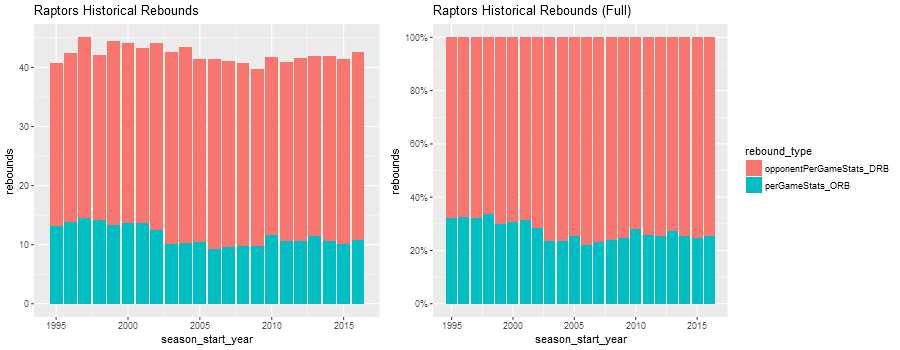

In [49]:
%%R -i rapsRbdDf -w 900 -h 350 -u px
rbdPlot(rapsRbdDf, 'Raptors')

In [52]:
leagueRbdDf = rbdPrepare()

     season_start_year              rebound_type   rebounds
0                 1946  opponentPerGameStats_DRB        NaN
1                 1946          perGameStats_ORB        NaN
2                 1947  opponentPerGameStats_DRB        NaN
3                 1947          perGameStats_ORB        NaN
4                 1948  opponentPerGameStats_DRB        NaN
5                 1948          perGameStats_ORB        NaN
6                 1949  opponentPerGameStats_DRB        NaN
7                 1949          perGameStats_ORB        NaN
8                 1950  opponentPerGameStats_DRB        NaN
9                 1950          perGameStats_ORB        NaN
10                1951  opponentPerGameStats_DRB        NaN
11                1951          perGameStats_ORB        NaN
12                1952  opponentPerGameStats_DRB        NaN
13                1952          perGameStats_ORB        NaN
14                1953  opponentPerGameStats_DRB        NaN
15                1953          perGameS

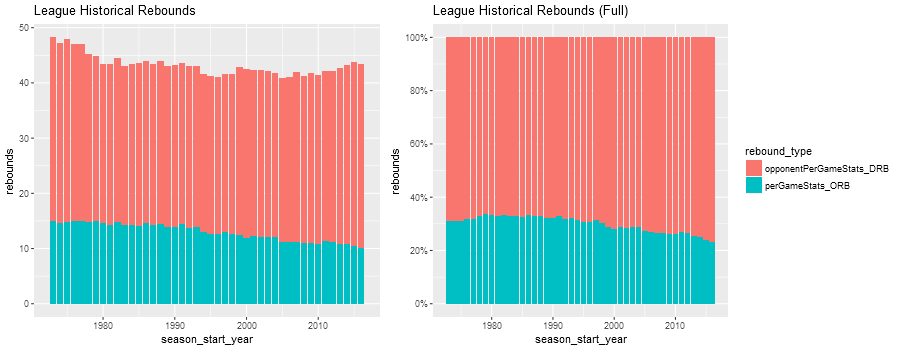

In [53]:
%%R -i leagueRbdDf -w 900 -h 350 -u px
rbdPlot(leagueRbdDf, 'League')

Unfortunately, we're not really seeing much of a difference than whwen we compared it to our own ORB / DRB.

In [71]:
teamAggRbdPercOrtgDf = teamAggDfToAnalyze[[
    'baseStats_ORtg',
    'opponentPerGameStats_DRB',
    'perGameStats_ORB'
]]

teamAggRbdPercOrtgDf['percent_rebound_orb'] = teamAggRbdPercOrtgDf['perGameStats_ORB']/(teamAggRbdPercOrtgDf['perGameStats_ORB']+teamAggRbdPercOrtgDf['opponentPerGameStats_DRB'])

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


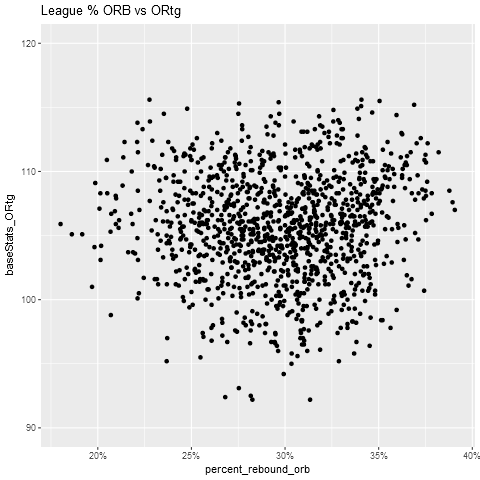

In [72]:
%%R -i teamAggRbdPercOrtgDf

# % ORB scatterplot
scatterRbdOrtg = ggplot(
    teamAggRbdPercOrtgDf,
    aes(
        x = percent_rebound_orb,
        y = baseStats_ORtg
    )
) + 
geom_point() +
ggtitle('League % ORB vs ORtg') +
scale_y_continuous(limits = c(90, 120)) +
scale_x_continuous(label = percent)

grid.arrange(scatterRbdOrtg, ncol = 1)

In [73]:
print teamAggRbdPercOrtgDf[['percent_rebound_orb', 'baseStats_ORtg']].corr('pearson').iat[0,1]

0.047627483999


And, wow, there is <span style="color:red">_**EVEN LESS CORRELATION**_</span>. This is absolutely amazing. I have to take a breather I think. My brain can't comprehend the lack of correlation. I must still be missing something. There has to be an astronomical piece that I'm not considering. Or perhaps it's just that offensive rebounds simply can't be looked at in a vacuum, or just don't matter that much in the grand scheme of things compared to other variables.